<a href="https://colab.research.google.com/github/shashwotpaudel/OpenSeesPyDoc/blob/master/miniapp_StateEquationSmoothedParticleHydrodynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal of this miniapp is purely to demonstrate the use and potential of smoothed particle hydrodynamics in fluid flows as a form of meshless method for solving a PDE. We will use an example problem of dam break to illustrate that.

In [66]:
"""Import all libraries"""
import numpy as np
# import os
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from tqdm.notebook import trange, tqdm
from IPython.display import HTML

# %matplotlib inline

**Navier Stokes equations** \\
*Conservation of momentum*
$$    \rho (\frac{\partial {\mathbf{u}}}{\partial t} + \mathbf{u} \cdot \nabla \mathbf{u}) = \rho \frac{D\mathbf{u}}{Dt}=- \nabla p + \nabla \cdot (\mu \nabla^S \mathbf{u}) + \rho \mathbf{g} + \rho \mathbf{f}$$

*Incompressibility constraint/ Continuity*
$$\frac{D \rho}{Dt} = 0 \Leftrightarrow \nabla \cdot \mathbf{u} = 0$$
where $\mathbf{u}$ is the velocity field, $\rho$ is the fluid density, $p$ is the pressure, $\mu$ is the dynamic viscosity, $\mathbf{g}$ is the acceleration due to gravity and $\mathbf{f}$ is additional body forces.
But we treat the SPH as a weakly compressible system with minimal density variations, the continuity equation is rewritten as:
$$\frac{D\rho}{Dt}= - \rho \nabla \cdot \mathbf{u}$$
The difference in between the Lagrangian and Eulerian derivatives on the left hand side of both of these equations must be carefully noted. The advection term $\mathbf{u} \cdot \nabla \mathbf{u}$ disappears in terms of Lagrangian derivative $\frac{D\mathbf{u}}{Dt}$. Thus, it becomes very easy for the momentum conservation law to be directly interpreted as Newton's second law of the form $\mathbf{F}= m \frac{D\mathbf{u}}{Dt}$.




**Smoothed Particle Hydrodynamics (SPH) for 2D Navier Stokes** \\
SPH, first introduced in [[1]](https://doi.org/10.1093/mnras/181.3.375) is a meshfree Lagrangian method (particle perspective), where the fluid domain is discretized into a number of "fluid" particles. It is especially good with simulating free-surface flows and complex boundary dynamics. However, handling different kinds of boundary conditions is more complicated with this method as the particles near the boundary do not necessarily conform to the geometry of the "container". \\
In this notebook, we attempt to simulate a **dam-break problem in 2D** using the most fundamental SPH technique that is not necessarily the most elegant or optimized. More on this later! \\
The discretization of the fluid domain is in terms of particles. The fluid field properties and their derivatives are reconstructed using the particles' position and properties alone. A fixed region of influence is set around each particle where a kernel function acts and provides weights to the properties. Finally, the particle properties are evolved through time based on the given PDE [[2]](https://dl.acm.org/doi/fullHtml/10.1145/3460773). \\
We consider a general smoothing function $W(\mathbf{r},h)$ for a continuous approximation to any quantity $A(\mathbf{x})$ as:
$$A(\mathbf{x}) = ∫A(\mathbf{x'})W(\mathbf{r},h)dv'$$ where $h$ denotes the kernel's smoothing length. [Koschier, Bender, Solenthaler] also describe a certain set of properties that neeed to be met by these kernel functions which are not discussed here. The SPH discretization further involves replacing of the above continuous integral by a sum over discrete sampling points such that:
$$A(\mathbf{x}_i)= \sum_j \frac{m_j}{\rho_j} A(\mathbf{x}_j)W(\mathbf{r}_{ij} = \mathbf{x}_i - \mathbf{x}_j, h)$$
We can replace $A$ with properties like $\rho$, $\nabla p$, $\nabla^2 \mathbf{u}$ and such. Note that we would need to calculate the gradient $\nabla W$ and laplacian $\nabla^2 W$ of the kernel functions for computing $\nabla p$ and $\nabla^2 \mathbf{u}$ respectively. \\
A typical choice for the smoothing kernel function used in SPH is the cubic spline kernel [[3]](https://doi.org/10.2312/egt.20191035) which is shown below.



**Kernel Functions** \\

In 2D, the cubic spline kernel function we use is:
$$W(\mathbf{r},h) = \sigma \begin{cases} 6(q^3 - q^2) + 1 && \text{for}  ~ 0\leq q\leq\frac{1}{2} \\2(1-q)^3 && \text{for} ~ \frac{1}{2} \lt q \leq 1 \\0 && \text{otherwise} \end{cases}$$
where $q=||\mathbf{r}||/h$ and $\sigma = \frac{40}{7 \pi h^2}$ for 2D. The kernel is $C^2$-continuous. \\
The gradient of the cubic spline kernel:
$$\nabla W(\mathbf{r},h) = \frac{\sigma}{h} \begin{cases} 3q^2 - 2q && \text{for}  ~ 0\leq q\leq\frac{1}{2} \\-6(1-q)^2 && \text{for} ~ \frac{1}{2} \lt q \leq 1 \\0 && \text{otherwise} \end{cases}$$
The laplacian of the cubic spline kernel:
$$\nabla^2 W(\mathbf{r},h) = \frac{\sigma}{h^2} \begin{cases} 6q - 2 && \text{for}  ~ 0\leq q\leq\frac{1}{2} \\12(1-q) && \text{for} ~ \frac{1}{2} \lt q \leq 1 \\0 && \text{otherwise} \end{cases}$$

There might be several other choices for the kernel functions which will not be discussed here.

In [67]:
def cubic_spline_kernel(r, h):
    q = r / h
    sigma = 40 / (7 * np.pi * h**2)
    return np.where(q <= 0.5, sigma * (6 * (q**3 - q**2) + 1), np.where((q > 0.5) & (q <= 1),sigma * 2 * (1 - q)**3, 0))

def grad_cubic_spline_kernel(r, h):
    q = r / h
    sigma = 40 / (7 * np.pi * h**2)
    return np.where(q <= 0.5, sigma * (3 * q**2 - 2 * q) / h, np.where((q > 0.5) & (q <= 1), -sigma * 6 * (1 - q)**2 / h, 0))

def laplacian_cubic_spline_kernel(r, h):
    q = r / h
    sigma = 40 / (7 * np.pi * h**2)
    return np.where(q <= 0.5, sigma * (6 * q - 2) / h**2, np.where((q > 0.5) & (q <= 1), sigma * 12 * (1 - q) / h**2, 0))

Some other kernel functions to try:

In [68]:
# Add other kernel functions here as needed

**Specify which kernel to use** \\
Only needed if you want to add more kernel functions to test the code. Right now, only the cubic spline kernels are supported.

In [69]:
kernel = cubic_spline_kernel
grad_kernel = grad_cubic_spline_kernel
laplacian_kernel = laplacian_cubic_spline_kernel

**Incompressibility** \\

The density of a particle $i$ is calculated directly using the kernel function $W$  such that $$\rho_i = \sum_j m_j W_{ij}$$
where $m_j$ is the mass of fluid particle $j$. \\
This method we employ is called explicit volume deviation which means that we explicitly calculate the fluid particle volume changes based on the densities of particles with respect to their relative positions from other particles. Although simple to use, it can result in fluid volume oscillations **(which this code suffers from)** due to over-correction of the pressure acceleration. \\
We can also use the time derivative of $\rho$ in the continuity equation to predict the particle density based on its previous density using a time integration scheme. This technique introduces volume drift and a volume loss can be observed. This technique does help with minimizing density deviations between time steps, but chances are the potentially existing density deviations are not detected. Since we do not include this technique in the code yet, this method is not elaborated further.  \\
For this code, a choice was made to use the explicit volume deviation to compute density deviation and hence pressure calculations discussed below.

**State Equation SPH** \\
The pressure is calculated based on Tait's equation of state.
$$p = \frac{K}{\gamma} \big[ \big(\frac{\rho}{\rho_0}\big)^{\gamma} -1 \big]$$
where $\rho_0$ is reference fluid density, $\rho$ is density at particle point. $K$ is equivalent to bulk modulus that governs the compressibility of the fluid. Higher $K$ means closer to incompressibility but requires smaller time steps but provides a better approximation to the density deviation which ultimately defines pressure. Lower $K$ means greater error in calculation of density deviation, which creates unrealistic physics and is undesirable. For water, $\gamma = 7$ is usually chosen [[6]](https://doi.org/10.1006/jcph.1994.1034). We also need to clamp the pressure values such that only non-negative pressure values exist for all particles. Negative pressure values imply existence of cavitations or surface tension forces which we do not include in this code.  
$$p_i = max(p_i,0)$$
SPH simulations using a state equation as described by Tait to compute pressure are often referred to as compressible or weakly compressible SPH systems. This work aligns with that theory as well. It is challenging to minimize compression using such state equations but they are easy to employ in code. Furthermore, for incompressibility, a Pressure Poisson Equation (PPE) needs to be solved which we do not include in this code.

**Pressure Forces** \\
We use the symmetric formula for gradient of kernel function which is derived in [[7]](https://ui.adsabs.harvard.edu/link_gateway/2012JCoPh.231..759P/doi:10.1016/j.jcp.2010.12.011).

$$\mathbf{f}_i^{pressure} = -\frac{\nabla p_i}{\rho_i} = -\sum_j m_j \bigg( \frac{p_i}{\rho_i ^2} + \frac{p_j}{\rho_j ^2} + Π_{ij} \bigg) \nabla W_{ij}$$
where $Π_{ij}$ is the artifical damping term.
$$Π_{ij} = \begin{cases} - \nu \bigg(\frac{u_{ij} \cdot r_{ij}}{r_{ij}^2 + 0.01 h^2} \bigg) && \text{if } \mathbf{u}_{ij} \cdot \mathbf{r}_{ij} < 0 \\0 && \text{otherwise} \end{cases}$$
where $\nu = \mu/\rho_i$ is the kinematic viscosity, $u_{ij}$ = $u_i-u_j$ and $r_{ij}=x_i - x_j$, $h$ is the smoothing length. \\
**Viscous Forces**
$$\mathbf{f}_i^{viscous} = \nu  \nabla^2 \mathbf{u}= \sum_j \nu m_j \bigg( \frac{u_j - u_i}{\rho_j} \bigg) \nabla^2 W_{ij}$$
These forces need not be included if the artificial viscosity mentioned above is incorporated in the pressure forces and vice versa.

The total force density ($F/ \rho$) or acceleration acting on any particle $i$ is then calculated as:
$$f_i = f_i^{pressure} + f_i^{viscous} + \text{ any other external forces like gravity}$$
Then, we solve for the velocity using a time integration scheme discussed below:

**Time Stepping**
This notebook supports 3 different time integration schemes, all of which are explicit, but with varying orders of accuracy. \\

This section describes the three time integration methods implemented in the Smoothed Particle Hydrodynamics (SPH) simulations, each with different orders of accuracy and stability characteristics.

1. Forward Euler Time Integration

The Forward Euler method is a first-order accurate scheme \(O(\Delta t)\). It is an explicit method that updates the positions and velocities using the current acceleration.

\begin{align*}
u_i^{n+1} &= u_i^n + \Delta t \cdot f_i, \\
x_i^{n+1} &= x_i^n + \Delta t \cdot u_i^{n+1},
\end{align*}

where $\ u_i $ and $ x_i$ are the velocity and position of the particle, $ f_i $ is the force per unit mass (acceleration), and $\Delta t$ is the time step.

2. Velocity Verlet Time Integration

The Velocity Verlet method is a second-order accurate scheme $O(\Delta t^2)$ that provides a good balance between computational efficiency and numerical stability. It calculates positions and velocities in a way that considers both the current and the new velocities within the same timestep:

\begin{align*}
u_i^{n+\frac{1}{2}} &= u_i^n + \frac{1}{2} \Delta t \cdot f_i^n, \\
x_i^{n+1} &= x_i^n + \Delta t \cdot u_i^{n+\frac{1}{2}}, \\
f_i^{n+1} &= f(x_i^{n+1}), \\
u_i^{n+1} &= u_i^{n+\frac{1}{2}} + \frac{1}{2} \Delta t \cdot f_i^{n+1}.
\end{align*}

This method updates the velocities in two half-steps and the positions in one full step, recalculating forces in between based on the updated positions.

3. RK4 (Runge-Kutta 4th Order) Time Integration

The RK4 method is a fourth-order accurate scheme $O(\Delta t^4)$ and is known for its high accuracy and stability in solving ordinary differential equations. It calculates the position and velocity by taking the weighted average of four increments, where each increment is calculated at a different point in the interval:

\begin{align*}
k1_v &= \Delta t \cdot f(x_i^n, u_i^n), \\
k1_x &= \Delta t \cdot u_i^n, \\
k2_v &= \Delta t \cdot f\left(x_i^n + \frac{1}{2} k1_x, u_i^n + \frac{1}{2} k1_v\right), \\
k2_x &= \Delta t \cdot (u_i^n + \frac{1}{2} k1_v), \\
k3_v &= \Delta t \cdot f\left(x_i^n + \frac{1}{2} k2_x, u_i^n + \frac{1}{2} k2_v\right), \\
k3_x &= \Delta t \cdot (u_i^n + \frac{1}{2} k2_v), \\
k4_v &= \Delta t \cdot f(x_i^n + k3_x, u_i^n + k3_v), \\
k4_x &= \Delta t \cdot (u_i^n + k3_v), \\
u_i^{n+1} &= u_i^n + \frac{1}{6}(k1_v + 2k2_v + 2k3_v + k4_v), \\
x_i^{n+1} &= x_i^n + \frac{1}{6}(k1_x + 2k2_x + 2k3_x + k4_x).
\end{align*}

This method requires four evaluations of the derivative per timestep but offers higher accuracy and stability. We currently employ the RK4 scheme in this code, but I have my doubts regarding the additional benefits, especially in my case where the time step is already too small.


**Time Step**
In SPH simulations, time step is a critical factor in determining the stability of the system. Depending on the compressibility constant or bulk modulus $K$, and the maximum affordable time step can be controlled using a CFL condition.$$\text{CFL} =  \mathbf{u} * \frac{\Delta t}{\Delta x} \leq \text{CFL}_{max}$$
where $Δx$ can be the amount of maximum allowable displacement (like the particle diameter) per time step and $\mathbf{u}$ is the characteristic velocity of the domain. To be the most restrictive, the maximum velocity of the particle can be taken. $\text{CFL}_{max}$ is the stability criterion taken as some value between $0$ and $1$. We have not implemented variable/adaptive time stepping based on CFL condition yet. \\
For most of the demo cases, $1\times 10^{-5}s$ was used, but for Colab time restrictions, the bulk modulus $K$ was reduced to reduce the maximum velocity in the domain, which allowed for larger time steps.

**Treatment of boundary** \\
In this work, we treat the boundary as reflective, and a damping coefficient is provided as input to decide the extent of inelastic loss. For now, we use a coefficient of $-1$ which corresponds to perfectly elastic reflection of particles back into the domain, but can be changed to any value between $0$ and $-1$ to provide some sort of damping on collision with wall. It would be more physical and realistic.

**Define classes for SPH fluid domain particles and boundary particles**

In [70]:
# Define a particle class
class SPHFluidDomain:
    def __init__(self, N, mass, domain_size_x, domain_size_y):
        self.x = np.zeros(N)  # X positions
        self.y = np.zeros(N)  # Y positions
        self.vx = np.zeros(N)  # X velocities
        self.vy = np.zeros(N)  # Y velocities
        self.rho = np.full(N, 1000.0)  # Density (initialized to density of water)
        self.mu = 1e-3 * np.ones(N)  # Viscosity
        self.P = np.zeros(N)  # Pressure
        self.fx = np.zeros(N)  # X force densities
        self.fy = np.zeros(N)   # Y force densities (gravity direction)
        self.mass = np.full(N, mass)  # Particle mass
        self.domain_size_x = domain_size_x
        self.domain_size_y = domain_size_y
        self.N = N

    # 2D Dam break water column initialization
    def initialize_positions(self, n_particles_x, n_particles_y, spacing):
        assert n_particles_x * n_particles_y == self.N, "Total number of particles does not match N"
        index = 0
        for i in range(n_particles_x):
            for j in range(n_particles_y):
                self.x[index] = 2 * spacing + i * spacing
                self.y[index] = 2 * spacing + j * spacing
                index += 1


    # Density and Pressure Estimation methods, uses State Equation SPH (SESPH)
    def compute_density_and_pressure(self, h, K, rho0):
        # Compute pairwise distances
        # print(self.x.dtype)
        dx = self.x[:, np.newaxis] - self.x
        dy = self.y[:, np.newaxis] - self.y
        r = np.sqrt(dx**2 + dy**2)

        # Apply kernel function to all distances
        weights = kernel(r, h)

        # Compute density
        self.rho = np.sum(weights * self.mass, axis=1)

        # Check and adjust density variations
        # rho_min = 0.7 * rho0
        # rho_max = 10.0 * rho0
        # self.rho = np.clip(self.rho, rho_min, rho_max)

        # Compute pressure and clamp to 0 if negative (Tait's equation of state)
        self.P = K / 7 * ((self.rho / rho0) ** 7 - 1)
        self.P = np.maximum(self.P, 0)  # Ensure non-negative

    # Three methods for time integration are implemented:
    # 1. Forward Euler
    # 2. Velocity Verlet
    # 3. RK4

    def update_fwd_euler(self, dt):
        self.vx += self.fx * dt
        self.vy += self.fy * dt
        self.x  += self.vx * dt
        self.y  += self.vy * dt

    def update_velocity_verlet(self, h, dt):
        # First half step for velocities
        self.vx += 0.5 * self.fx * dt
        self.vy += 0.5 * self.fy * dt
        # Update positions
        self.x += self.vx * dt
        self.y += self.vy * dt
        # Update forces and compute new accelerations
        self.compute_force_density(h)
        # self.apply_soft_boundary(damping,h)
        # Second half step for velocities
        self.vx += 0.5 * self.fx * dt
        self.vy += 0.5 * self.fy * dt

    def update_rk4(self, h,  dt):
        # copy to new variables to use after step 4
        initial_x = np.copy(self.x)
        initial_y = np.copy(self.y)
        initial_vx = np.copy(self.vx)
        initial_vy = np.copy(self.vy)

        # step 1
        self.compute_force_density(h)
        ax1, ay1 = self.fx, self.fy
        k1_vx = dt * ax1
        k1_vy = dt * ay1
        k1_x = dt * initial_vx
        k1_y = dt * initial_vy

        # step 2
        self.x = initial_x + 0.5 * k1_x
        self.y = initial_y + 0.5 * k1_y
        self.vx = initial_vx + 0.5 * k1_vx
        self.vy = initial_vy + 0.5 * k1_vy
        self.compute_force_density(h)
        ax2, ay2 = self.fx, self.fy
        k2_vx = dt * ax2
        k2_vy = dt * ay2
        k2_x = dt * (initial_vx + 0.5 * k1_vx)
        k2_y = dt * (initial_vy + 0.5 * k1_vy)

        # step 3
        self.x = initial_x + 0.5 * k2_x
        self.y = initial_y + 0.5 * k2_y
        self.vx = initial_vx + 0.5 * k2_vx
        self.vy = initial_vy + 0.5 * k2_vy
        self.compute_force_density(h)
        ax3, ay3 = self.fx, self.fy
        k3_vx = dt * ax3
        k3_vy = dt * ay3
        k3_x = dt * (initial_vx + 0.5 * k2_vx)
        k3_y = dt * (initial_vy + 0.5 * k2_vy)

        # step 4
        self.x = initial_x + k3_x
        self.y = initial_y + k3_y
        self.vx = initial_vx + k3_vx
        self.vy = initial_vy + k3_vy
        self.compute_force_density(h)
        ax4, ay4 = self.fx, self.fy
        k4_vx = dt * ax4
        k4_vy = dt * ay4
        k4_x = dt * (initial_vx + k3_vx)
        k4_y = dt * (initial_vy + k3_vy)

        # Combine steps to produce final estimate
        self.x = initial_x + (k1_x + 2*k2_x + 2*k3_x + k4_x) / 6
        self.y = initial_y + (k1_y + 2*k2_y + 2*k3_y + k4_y) / 6
        self.vx = initial_vx + (k1_vx + 2*k2_vx + 2*k3_vx + k4_vx) / 6
        self.vy = initial_vy + (k1_vy + 2*k2_vy + 2*k3_vy + k4_vy) / 6

    # Compute force densities/ accelerations, includes:
    # 1. Pressure Forces
    # 2. Viscous Forces
    # 3. Gravity Forces

    def compute_force_density(self, h):
        # Compute pairwise distances
        dx = self.x[:, np.newaxis] - self.x
        dy = self.y[:, np.newaxis] - self.y
        r = np.sqrt(dx**2 + dy**2)

        # Calculate gradients and Laplacians
        grad_k = grad_kernel(r, h)
        lap_k = laplacian_kernel(r, h)

        # Normalize directions
        grad_kx = np.where(r > 0, grad_k * dx / r, 0)
        grad_ky = np.where(r > 0, grad_k * dy / r, 0)
        # print(grad_kx)

        # Initialize force densities to 0
        self.fx = np.zeros(self.N)
        self.fy = np.zeros(self.N)

        # Pressure forces
        pressure_term = self.mass * (self.P[:, np.newaxis] / self.rho[:, np.newaxis]**2 + self.P / self.rho**2)
        self.fx += -np.sum(pressure_term * grad_kx, axis=1)
        self.fy += -np.sum(pressure_term * grad_ky, axis=1)

        # Viscous forces, either this one or use artifical viscosity
        lap_kx = np.where(r > 0, lap_k, 0)
        lap_ky = np.where(r > 0, lap_k, 0)
        viscous_term_x = self.mu / self.rho * self.mass * (self.vx[:, np.newaxis] - self.vx) / self.rho[:, np.newaxis]
        viscous_term_y = self.mu / self.rho * self.mass * (self.vy[:, np.newaxis] - self.vy) / self.rho[:, np.newaxis]
        self.fx += np.sum(viscous_term_x * lap_kx, axis=1)
        self.fy += np.sum(viscous_term_y * lap_ky, axis=1)

        # Add gravity (-y direction)
        self.fy -= 9.81

    # alternative viscous force contribution, use artificial viscosity or include the laplacian terms
    # Parameters might need tuning, but currently these values of alpha = 0.1 and beta = 0 seem to be working fine for our case
    def compute_artificial_viscosity(self, h, alpha=0.1, beta=0.0):
        # pairwise distances and velocity differences
        dx = self.x[:, np.newaxis] - self.x
        dy = self.y[:, np.newaxis] - self.y
        dvx = self.vx[:, np.newaxis] - self.vx
        dvy = self.vy[:, np.newaxis] - self.vy

        r = np.sqrt(dx**2 + dy**2)
        vij_dot_rij = (dvx * dx + dvy * dy)

        # mask for particles approaching each other
        approaching_mask = vij_dot_rij < 0

        # calculate artificial viscosity only for approaching particles
        rho_ij = (self.rho[:, np.newaxis] + self.rho) / 2
        c_ij = np.sqrt(K / rho_ij)
        mu_ij = h * vij_dot_rij / (r**2 + 0.01*h**2)  # Adding a small term to avoid DIV/0! error

        pi_ij = (-alpha * c_ij * mu_ij + beta * mu_ij**2) * approaching_mask / rho_ij

        # Calculate force contributions
        grad_k = grad_kernel(r, h)

        # Normalize directions
        grad_kx = np.where(r > 0, grad_k * dx / r, 0)
        grad_ky = np.where(r > 0, grad_k * dy / r, 0)

        # Viscous force contributions
        self.fx -= np.sum(self.mass * pi_ij * grad_kx, axis=1)
        self.fy -= np.sum(self.mass * pi_ij * grad_ky, axis=1)

    # Apply boundary conditions (reflective)
    def apply_soft_boundary(self, damping, h):
        epsilon = 0.1 * h
        # Left boundary
        left_mask = self.x < 2 * h + epsilon
        # print(left_mask.shape)
        self.vx[left_mask] *= damping
        # self.vy[left_mask] *= -damping
        self.x[left_mask] = 2*h + epsilon
        # self.rho[left_mask] = rho0 # to make sure the density of particles near boundary is rho0, testing

        # Right boundary
        right_mask = self.x > self.domain_size_x - 2 * h - epsilon
        # print(right_mask.shape)
        self.vx[right_mask] *= damping
        # self.vy[right_mask] *= -damping
        self.x[right_mask] = self.domain_size_x - 2*h  - epsilon
        # self.rho[right_mask] = rho0

        # Bottom boundary
        bottom_mask = self.y < 2 * h + epsilon
        self.vy[bottom_mask] *= damping
        # self.vx[bottom_mask] *= -damping
        self.y[bottom_mask] = 2 * h + epsilon
        # self.rho[bottom_mask] = rho0

        # Upper boundary
        upper_mask = self.y > self.domain_size_y - 2*h - epsilon
        self.vy[upper_mask] *= damping
        # self.vx[upper_mask] *= -damping
        self.y[upper_mask] = self.domain_size_y - 2*h  - epsilon
        # self.rho[upper_mask] = rho0

    # Check for maximum speed in the domain, debug
    def check_max_speed(self):
        max_speed = np.max(np.sqrt(self.vx**2 + self.vy**2))
        if max_speed > np.sqrt(2 * 9.81 * 1):
            print(f"Max speed is {max_speed}")

    # Energy Conservation check, check if total Kinetic and Potential energy of all particles is conserved in the domain
    def total_energy(self):
        KE = 0.5 * np.sum(self.mass * (self.vx**2 + self.vy**2))  # 1/2 mv^2
        PE = np.sum(self.mass * 9.81 * self.y)  # mgy, assuming gravity acts in the y-direction
        return KE + PE

**Boundary** \\
The boundary particles specified here are only for visualization and these classes and functions are remnants of an earlier attempt to include them in the simulation, but could not afford the computational burden of the additional particles. Currently, the code is still at $O(N^2)$ complexity, so unless some kind of neighbor list is implemented, inclusion of boundary particles would be very computationally inefficient and SLOW.

In [71]:

"""Boundary particles for visualization only"""

# Define a boundary particle class, used for visualizing boundary only
"""Note that only positions are defined for boundary particles as we dont use anything else"""
class BoundaryParticle:
    def __init__(self,x,y, mass):
        self.x = x
        self.y = y
        self.vx = 0  # Velocities
        self.vy = 0
        self.rho = 1000.0  # Density of water
        self.mu = 1  # Viscosity, might not be used
        self.P = 0  # Pressures
        self.fx = 0.0  # Forces/acclns
        self.fy =  0.0 # mass * -9.81 # gravity force in y-direction
        self.mass = mass # Particle mass

def initialize_boundary_particles(n_boundary_x, n_boundary_y, domain_size_x, domain_size_y, spacing, mass):
    boundary_particles = []
    thickness = 2
    # bottom and top boundaries
    for i in range(n_boundary_x):
      for j in range(thickness):
        # bottom boundary
        x = i * spacing
        y = j * spacing
        boundary_particles.append(BoundaryParticle(x,y, mass))
        # top boundary
        y = domain_size_y - j * spacing
        boundary_particles.append(BoundaryParticle(x,y, mass))
    # left and right boundaries
    for i in range(1,n_boundary_y - 1): # exclude the corners counted above
      for j in range(thickness):
        # left boundary
        x = j * spacing
        y = i * spacing
        boundary_particles.append(BoundaryParticle(x,y, mass))
        # right boundary
        x = domain_size_x - j * spacing
        boundary_particles.append(BoundaryParticle(x,y, mass))
    return boundary_particles


**2D Dam break Simulation Setup** \\
We specify all the necessary parameters here for setting up the fluid domain, material properties like density $\rho$, bulk modulus $K$, damping against wall, etc. Similarly, we also specify the particle size based on spacing, kernel smoothing length $h$, simulation time step $dt$. \\

We set the size of the water column in the dam. Note that higher dam height (controlled by $n^{particles}_y$) will increase the stiffness/bulk modulus and restrict the time step further leading to instability. It would be nice to include a variable time-stepping algorithm based on a simple CFL condition to try to control the instability, although this would not entirely solve the problem. \\
Also, we keep the mass of each particle fixed throughout the simulation, which means mass is conserved globally but local conservation is based on the density evaluation at each point and might not be conserved locally.

It should also be mentioned that the bulk modulus is calculated based on the maximum fluid velocity in the domain to ensure incompressibility when using the state equations for pressure calculations. \\

$$K = \frac{\rho_0 c_0^2}{\gamma}$$
where $\rho_0$ is the reference density, $c_0$ is the speed of sound in water which is not directly specified and instead based on the water column height for relaxing the time step criterion $\Delta t$. Also, $\gamma = 7$ for water is used.
$$c_0 = \beta \sqrt{2gH}$$
where $\beta$ is a factor usually taken as 10, and $H$ is the water column height. We take $\beta=3$ for relaxing the time step constraint a little bit for use in Colab.

In [72]:
# Simulation Setup and Parameters
n_particles_x, n_particles_y = 15 , 10  # Number of particles in x and y directions
spacing = 0.02   # Particle spacing
h = 1.2 * spacing  # Smoothing length
# find the numerically "good" value for K
c0 = 3.0 * np.sqrt(n_particles_y * spacing * 9.81 * 2)  # "Speed" of sound
rho0 = 1000.0  # Reference density
K = (rho0*c0**2) /7  # Bulk modulus

mass = rho0 * spacing**2  # In 2D, we assume mass to be rho * h^2
damping = -1.0  # for soft boundary reflection,  -1.0 for perfect reflection, 0.0 for no reflection
dt0 = 0.0005  # Time step, use 1e-5 or smaller if you increase the water column height
dt = dt0  # In case I add the variable time stepping routine, not implemented yet
CFL = 0.4 # Not implemented yet
n_steps = 1000  # Number of simulation steps
Domain_X = 0.8
Domain_Y = 0.5
n_boundary_x = int(Domain_X/spacing) + 1
n_boundary_y = int(Domain_Y/spacing) + 1

# Initialize SPH domain for fluid particles
domain = SPHFluidDomain(n_particles_x * n_particles_y, mass, Domain_X, Domain_Y)
domain.initialize_positions(n_particles_x, n_particles_y, spacing)
# Initialize the boundary particles
boundary_particles = initialize_boundary_particles(n_boundary_x, n_boundary_y, Domain_X, Domain_Y, spacing, mass)

In [73]:
print("------------------------------")
print("### Simulation Parameters ###")
print("------------------------------")
print("Time Step = ", dt, " seconds")
print("Damping factor for wall collision = ", damping)
print("Width of water column = ", n_particles_x * spacing, "m.")
print("Height of water column = ", n_particles_y * spacing, "m.")
print("Smoothing Length for kernel function = ", h, "m.")
print("Stiffness or Bulk Modulus = ", K, "Pa")
print("Mass of each fluid particle = ", mass, "kg.")
print("Density of water = ", rho0, r'kg/m^3')
print("Viscosity of water = ", 1e-3, "Pa.s")
print("------------------------------")
print("The simulation will run for ", n_steps, "steps for a final physical time of ", n_steps*dt, " seconds.")

------------------------------
### Simulation Parameters ###
------------------------------
Time Step =  0.0005  seconds
Damping factor for wall collision =  -1.0
Width of water column =  0.3 m.
Height of water column =  0.2 m.
Smoothing Length for kernel function =  0.024 m.
Stiffness or Bulk Modulus =  5045.142857142858 Pa
Mass of each fluid particle =  0.4 kg.
Density of water =  1000.0 kg/m^3
Viscosity of water =  0.001 Pa.s
------------------------------
The simulation will run for  1000 steps for a final physical time of  0.5  seconds.


**Setup for plotting and visualization**

time step:   0%|          | 0/1000 [00:00<?, ?it/s]

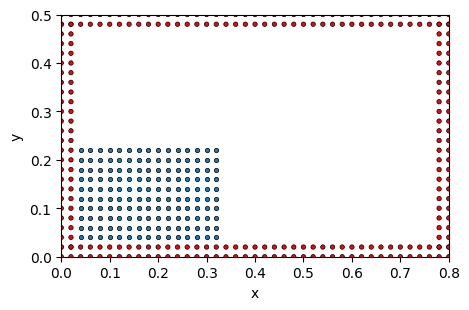

In [74]:
# Visualization setup
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlim(0, Domain_X)
ax.set_ylim(0, Domain_Y)
ax.set_aspect('equal')
scat_fluid = ax.scatter(domain.x, domain.y, edgecolors='black', linewidths=0.5, s=10)
scat_boundary = ax.scatter([],[], color='red')
scat_boundary.set_edgecolors('black')
scat_boundary.set_linewidths(0.5)
scat_boundary.set_sizes([10] * len(boundary_particles))
plt.xlabel('x')
plt.ylabel('y')
scat_boundary.set_offsets([[p.x, p.y] for p in boundary_particles])

def update(frame):
    domain.compute_density_and_pressure(h, K, rho0)
    domain.compute_force_density(h)
    domain.compute_artificial_viscosity(h)
    domain.update_rk4(h, dt)
    domain.apply_soft_boundary(damping, spacing)
    # Append energy at this state
    Energy.append(domain.total_energy())
    # Update plots
    scat_fluid.set_offsets(np.column_stack((domain.x, domain.y)))
    scat_boundary.set_offsets([[p.x, p.y] for p in boundary_particles])
    if(frame%100 ==0 or frame == 1):
      plt.savefig(f'./plot_{frame}.png')

Energy = [domain.total_energy()]

# # Create the animation
ani = FuncAnimation(fig, update, frames=tqdm(range(1,n_steps+1), desc='time step', position=1, leave=True), interval=1000)
# plt.close()
plt.show()
# HTML(ani.to_jshtml())

In [75]:
# # Time stepping
# for i in trange(n_steps+1, desc='time step', position=0, leave=True):
#     print("Time step: ", i, end="\r ")
#     update(i)
#     # if(ii%100 == 0):
#     #   scat_fluid.set_offsets(np.column_stack((domain.x, domain.y)))
#     #   scat_boundary.set_offsets([[p.x, p.y] for p in boundary_particles])
#     #   domain.check_max_speed()
#     #   # plot to png
#     #   plt.savefig(f'./plot_{ii}.png')


Uncomment the following cell to write to a mp4 file, also need to uncomment the update_visualization part in the update() routine and the animation creation part as well in the earlier cell

In [76]:
# Save the animation
writer = FFMpegWriter(fps=120, metadata=dict(artist='Me'), bitrate=5000)
ani.save('sph_simulation.mp4', writer=writer)
plt.show()

<ipython-input-70-46fcbe1cceb0>:150: RuntimeWarning: invalid value encountered in divide
  grad_kx = np.where(r > 0, grad_k * dx / r, 0)
<ipython-input-70-46fcbe1cceb0>:151: RuntimeWarning: invalid value encountered in divide
  grad_ky = np.where(r > 0, grad_k * dy / r, 0)
<ipython-input-70-46fcbe1cceb0>:200: RuntimeWarning: invalid value encountered in divide
  grad_kx = np.where(r > 0, grad_k * dx / r, 0)
<ipython-input-70-46fcbe1cceb0>:201: RuntimeWarning: invalid value encountered in divide
  grad_ky = np.where(r > 0, grad_k * dy / r, 0)


<Figure size 640x480 with 0 Axes>

The div/0 error seen above is because of the diagonal terms of grad_k which calculate the distance of a particle with itself. Did not correct this, but does not affect the simulation as those values are not used.

We try to plot the total energy of the system through time, and some instability issues around the end grow large enough because of our explicit scheme usage as well. I believe with proper stability control, energy conservation can also be verified for the model. Moreover, too few particles are used to simulate a continuous medium which is unrealistic. Also, as stated earlier, volume oscillations are very high when using the state equation SPH for pressure estimation.

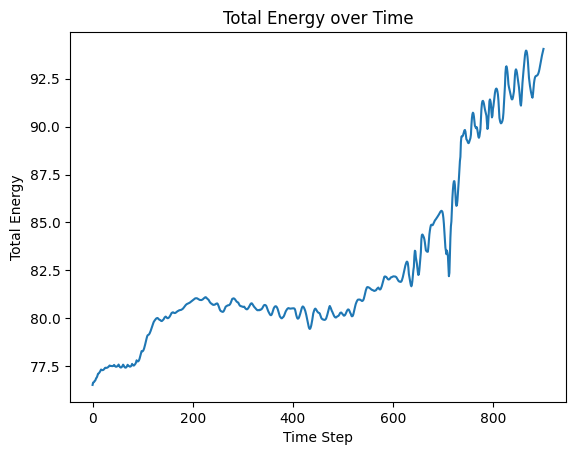

In [78]:

# Plot the energy with time
plt.figure()
plt.plot(Energy[:-100])
# plt.ylim([40,60])
plt.xlabel('Time Step')
plt.ylabel('Total Energy')
plt.title('Total Energy over Time')
plt.savefig("energy.png")

**References**

1.   Gingold, Robert A., and Joseph J. Monaghan. "Smoothed particle hydrodynamics: theory and application to non-spherical stars." Monthly notices of the royal astronomical society 181.3 (1977): 375-389
2.   Prabhu Ramachandran, Aditya Bhosale, Kunal Puri, Pawan Negi, Abhinav Muta, A. Dinesh, Dileep Menon, Rahul Govind, Suraj Sanka, Amal S. Sebastian, Ananyo Sen, Rohan Kaushik, Anshuman Kumar, Vikas Kurapati, Mrinalgouda Patil, Deep Tavker, Pankaj Pandey, Chandrashekhar Kaushik, Arkopal Dutt, and Arpit Agarwal. 2021. PySPH: A Python-based Framework for Smoothed Particle Hydrodynamics. ACM Trans. Math. Softw. 47, 4, Article 34 (December 2021), 38 pages. https://doi.org/10.1145/3460773
3.   Koschier, Dan, et al. "Smoothed particle hydrodynamics techniques for the physics based simulation of fluids and solids." arXiv preprint arXiv:2009.06944 (2020)
4.   Tutorial from https://sph-tutorial.physics-simulation.org/
5.   Egor Larionov. "SPH for Weakly Compressible Fluids"
6.   Monaghan, Joe J. "Simulating free surface flows with SPH." Journal of computational physics 110.2 (1994): 399-406. https://doi.org/10.1006/jcph.1994.1034
7.   Price, D. J. (2010). Smoothed Particle Hydrodynamics and Magnetohydrodynamics. ArXiv. https://doi.org/10.1016/j.jcp.2010.12.011
8.   SPH Example https://github.com/AhmedSalih3d/SPHExample





**Future Works**


1.   Code complexity reduction from $O(N^2)$ to $O(N)$ using some sort of neighbor storing algorithm
2.   Parallelization
2.   Implement Pressure Poisson Equation solver to calculate realistic pressure values over the domain that agree with the continuity equation, i.e. the divergence of velocity is minimized (PPESPH)
1.   Kernel and its gradient Corrections are applied in a lot of SPH works, which have not been dealt with here
2.   Implementation of near pressure and near densities for all particles which are activated only when the particles are close to the boundary, so that the density deviations near the boundary are minimized as much as possible, improving the realism of the simulations
2.   We can also add penalty force boundaries or even incorporate boundary particles (particle-based boundary handling) altogether when code complexity decreases
1.   Inclusion of surface tension forces
2.   Inclusion of CFL condition for adaptive time-stepping




